In [26]:
import oandapyV20
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.instruments as instruments
import json
import pandas as pd
import datetime as dt
import numpy as np

In [27]:
client = oandapyV20.API(access_token="0ca9619de6d428b6fdbcb4d20ef81268-cca1610e83cde7da5395d4468c2c1fe9")

performanceSummary = pd.DataFrame()
cols = ['Pair', 'Start Date', 'End Date', 'Total Trades', 'Avg Winning in Pips', 'Avg Losing in Pips', 'Total Pips Earned']

pair = 'NZD_USD'

cols = ['Date', 'Close']
dailyPrices = pd.DataFrame(columns=cols)
r = instruments.InstrumentsCandles(instrument=pair,
                               params={"count": 5000, "granularity": "D"})
raw_data = client.request(r)
candles = raw_data['candles']
for m in candles:
    new_row = {'Date': dt.datetime.strptime(m['time'][:10], '%Y-%m-%d'), 
               'Close': float(m['mid']['c'])}
    dailyPrices=dailyPrices.append(new_row, ignore_index=True)

shortTerm = 60
longTerm = 240

dailyPrices['EMA ' + str(shortTerm)] = dailyPrices['Close'].rolling(window=shortTerm).mean().round(5)
dailyPrices['EMA ' + str(longTerm)] = dailyPrices['Close'].rolling(window=longTerm).mean().round(5)

dailyPrices.set_index('Date',inplace=True)
dailyPrices.dropna(inplace=True)
dailyPrices['Close'] = dailyPrices['Close'].round(4)

longPos, shortPos, num, nTrades = 0,0,0,0
nPips = 0
wealth = 1
returns = []
pips = []
ST = dailyPrices.columns[1]
LT = dailyPrices.columns[2]
bullStart = False
bearStart = False

dailyPrices['trading_book'] = wealth

for date in dailyPrices.index:
    if num == 0:
        if dailyPrices[ST][date] > dailyPrices[LT][date]:
            bullStart = True
        else:
            bearStart = True
    close = dailyPrices['Close'][date]    
    # BUY SIGANL WHEN SHORT TERM EMA IS GREATER THAN LONG TERM EMA    
    if dailyPrices[ST][date] > dailyPrices[LT][date]:
        if shortPos > 0:
            closeShort = close
            shortPos = 0
            print("Closed short position at {} on {}".format(closeShort,date))
            print("===========================")
            ret = -(closeShort/openShort - 1).round(3)
            returns.append(ret)
            pipEarned = -(closeShort - openShort) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))

            wealth = wealth * (ret + 1)


        elif longPos == 0 and shortPos == 0 and bullStart == False:
            nTrades += 1
            openLong = close
            longPos = 1
            bearStart = False
            print("Opened long position at {} on {}".format(openLong,date))           
    # SELL SIGNAL WHEN SHOR TERM EMA IS SMALLER THAN LONG TERM EMA            
    elif dailyPrices[ST][date] < dailyPrices[LT][date]:
        if longPos > 0:
            closeLong = close
            longPos = 0
            print("Closed long position at {} on {}".format(closeLong,date))
            print("===========================")
            ret = (closeLong/openLong - 1).round(3)
            returns.append(ret) 
            pipEarned = (closeLong - openLong) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))
            wealth = wealth * (ret + 1)
            #dailyPrices.loc[date]['trading_book'] = 'closeLong'
        elif shortPos == 0 and longPos == 0 and bearStart == False:
            nTrades += 1
            openShort = close
            shortPos = 1
            bullStart = False
            print("Opened short position at {} on {}".format(openShort,date))            

    # SELL THE REMAINING POSITION AT THE END OF DATA            
    if (num == dailyPrices['Close'].count() - 1):
        # long position not closed
        if longPos != 0:
            closeLong = close
            longPos = 0
            print("Closed long position at {} on {}".format(closeLong,date))
            print("===========================")
            ret = (closeLong/openLong - 1).round(3)
            returns.append(ret)  
            pipEarned = (closeLong - openLong) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))
            wealth = wealth * (ret + 1)

        if shortPos != 0:
            closeShort = close
            shortPos = 0
            print("Closed short position at {} on {}".format(closeShort,date))
            print("===========================")
            ret = -(closeShort/openShort - 1).round(3)
            returns.append(ret)
            pipEarned = -(closeShort - openShort) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))
            wealth = wealth * (ret + 1)

    num += 1
    dailyPrices.loc[date,'trading_book'] = wealth

returns = returns[1:]
pips = pips[1:]

nLosing = 0
nWinning = 0
losingSum = 0
winningSum = 0

for pip in pips:
    if pip <= 0:
        nLosing += 1
        losingSum = losingSum + pip
    else:
        nWinning += 1
        winningSum = winningSum + pip

avgWinning = winningSum/nWinning
avgLosing = losingSum/nLosing


performanceSummary = performanceSummary.append({'Pair': pair,
                                               'Start Date': dailyPrices.index[0],
                                               'End Date': dailyPrices.index[-1],
                                               'Total Trades': int(len(pips)),
                                               'Avg Winning in Pips': int(avgWinning), 
                                               'Avg Losing in Pips': int(avgLosing),
                                               'Total Pips Earned': sum(pips)}, ignore_index=True)

performanceSummary.set_index('Pair', inplace=True)

performanceSummary = performanceSummary[['Start Date', 
                                         'End Date', 
                                         'Total Trades', 
                                         'Total Pips Earned', 
                                         'Avg Winning in Pips', 
                                         'Avg Losing in Pips']]


    

Opened short position at 0.6806 on 2005-07-03 00:00:00
Closed short position at 0.6528 on 2006-09-28 00:00:00
Opened long position at 0.6528 on 2006-09-29 00:00:00
Closed long position at 0.7577 on 2007-10-01 00:00:00
Opened short position at 0.7548 on 2007-10-02 00:00:00
Closed short position at 0.7661 on 2007-10-25 00:00:00
Opened long position at 0.7678 on 2007-10-27 00:00:00
Closed long position at 0.7591 on 2008-06-17 00:00:00
Opened short position at 0.7627 on 2008-06-18 00:00:00
Closed short position at 0.6248 on 2009-05-25 00:00:00
Opened long position at 0.6143 on 2009-05-26 00:00:00
Closed long position at 0.7078 on 2010-03-19 00:00:00
Opened short position at 0.707 on 2010-03-20 00:00:00
Closed short position at 0.7333 on 2010-08-05 00:00:00
Opened long position at 0.7331 on 2010-08-06 00:00:00
Closed long position at 0.801 on 2011-10-25 00:00:00
Opened short position at 0.8228 on 2011-10-26 00:00:00
Closed short position at 0.836 on 2012-02-23 00:00:00
Opened long position 

<AxesSubplot:title={'center':'NZD_USD MA CrossOver L/S Strategy Backtesting'}, xlabel='Date'>

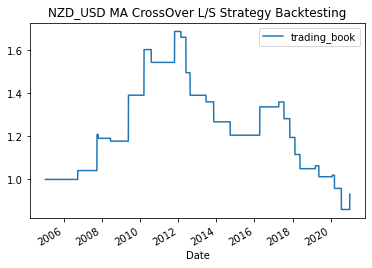

In [28]:
dailyPrices.plot(y='trading_book', title=pair + ' MA CrossOver L/S Strategy Backtesting')

In [29]:
performanceSummary

,Start Date,End Date,Total Trades,Total Pips Earned,Avg Winning in Pips,Avg Losing in Pips
Pair,,,,,,
NZD_USD,2005-01-18,2020-12-30,25.0,-505.0,632.0,-387.0
